# 🧠 Tensor Indexing & Axis Reminder

## 🔹 Core Rule

For a tensor of shape:

(d0, d1, d2, ..., dn)

Indexing always follows:

tensor[i0, i1, i2, ..., in]

Each comma corresponds to one axis.

---

## 🔹 The Golden Rules

1. `:` → keeps the entire axis  
2. A number (e.g., `2`) → selects one index and **removes that axis**  
3. A slice (e.g., `2:4`) → keeps that axis but reduces its size  

---

## 🔹 2D Example

If:

X.shape = (3, 2)

X =  
[[1, 2],  
 [3, 4],  
 [5, 6]]

- `X[:, 0]` → shape (3,)  
  → selects first column (axis 1 removed)

- `X[0, :]` → shape (2,)  
  → selects first row (axis 0 removed)

---

## 🔹 3D Example

If:

X.shape = (4, 3, 2)

Meaning:
- 4 blocks
- 3 rows per block
- 2 columns per row

- `X[:, 1, :]` → shape (4, 2)  
  → selects row index 1 from every block  
  → axis 1 removed

- `X[:, 1:2, :]` → shape (4, 1, 2)  
  → slice keeps axis 1 (size 1)

---

## 🔹 4D Example (Deep Learning Style)

T.shape = (2, 5, 4, 3)

- `T[:, 2, :, 1]` → shape (2, 4)  
  → axis 1 and axis 3 removed

- `T[:, 2:4, :, 1]` → shape (2, 2, 4)  
  → axis 1 kept (size 2 because slice)  
  → axis 3 removed

---


In [1]:
# Lets import a dataset, this one returns a set of points that form a circle
from sklearn.datasets import make_circles

n_samples=1000 # how many points we want
A, b= make_circles(n_samples, noise=0.1, random_state=42) # noise is the amount by which the points deviate from a perfect circle

In [2]:
A.shape, b.shape

((1000, 2), (1000,))

In [3]:
import pandas as pd
circles= pd.DataFrame({"x": A[:,0], "y": A[:,1], "label":b})
circles.head(10)

,x,y,label
0,0.712108,0.284698,1
1,-0.678716,0.207274,1
2,-0.866026,0.343651,1
3,-0.517648,0.620599,1
4,0.454089,-0.890466,0
5,-0.445483,0.787044,1
6,-0.022038,0.811310,1
7,0.729897,0.188943,1
8,-0.191616,-0.815790,1
9,-0.083442,1.093954,0


In [4]:
circles.label.value_counts()

,count
label,
1,500
0,500


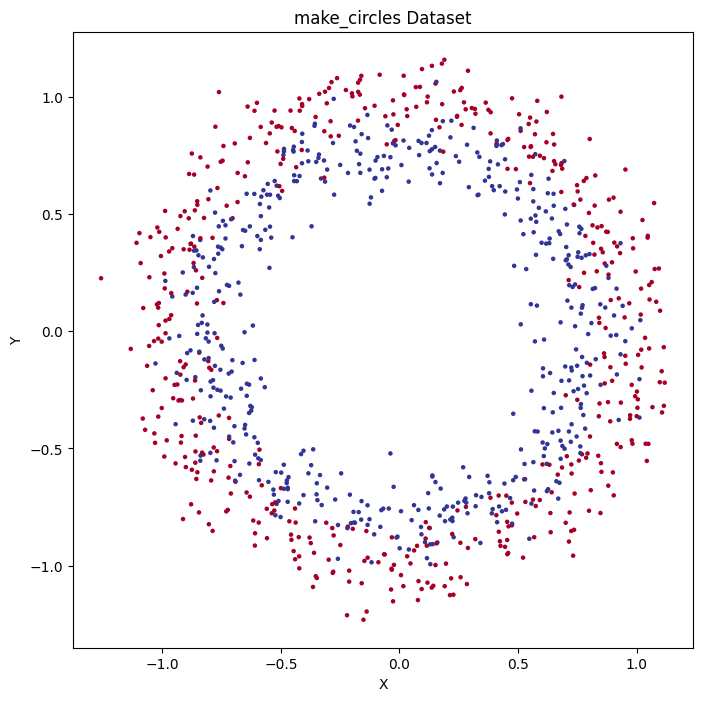

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))

# color by label `b`
plt.scatter(
    x=A[:,0],
    y=A[:,1],
    c=b,                 
    cmap=plt.cm.RdYlBu,   
    s=5                   
)

plt.xlabel('X')
plt.ylabel('Y')
plt.title('make_circles Dataset')
plt.show()


In [6]:
import torch
# First lets convert them to tensors
coordinates= torch.from_numpy(A).type(dtype=torch.float32)
labelValues= torch.from_numpy(b).type(dtype=torch.float32)

# Now lets split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(coordinates, labelValues, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


(torch.Size([700, 2]),
 torch.Size([300, 2]),
 torch.Size([700]),
 torch.Size([300]))

In [7]:
from torch import nn

class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1= nn.Linear(in_features=2, out_features=5)
        self.layer2= nn.Linear(in_features=5, out_features=1)
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer2(self.layer1(x))

model_circle_0= CircleModel()
with torch.inference_mode():
    y_pred= model_circle_0(X_train)

print(y_pred[:10])
print(y_test[:10])


tensor([[-0.3956],
        [-0.2880],
        [-0.0695],
        [-0.1203],
        [-0.4500],
        [-0.0041],
        [-0.0758],
        [-0.0696],
        [-0.0301],
        [-0.5122]])
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [8]:
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score

lossFn= torch.nn.BCEWithLogitsLoss()
optimizer= torch.optim.SGD( params=model_circle_0.parameters(), lr=0.01)
epochs= 1000
for epoch in range(epochs):
    model_circle_0.train()
    y_logits_train= model_circle_0(X_train).squeeze()
    y_pred_train= torch.round(torch.sigmoid(y_logits_train))
    
    loss= lossFn(y_logits_train, y_train)
    acc= accuracy_score(y_train.detach().numpy(),y_pred_train.detach().numpy())
    prec= precision_score(y_train.detach().numpy(), y_pred_train.detach().numpy())
    
    optimizer.zero_grad()
    
    loss.backward()
    
    optimizer.step()
    
    model_circle_0.eval()
    with torch.inference_mode():
        y_logits_test= model_circle_0(X_test).squeeze()
        y_pred_test= torch.round(torch.sigmoid(y_logits_test))
        test_loss= lossFn(y_logits_test, y_test)
        test_acc= accuracy_score(y_test.detach().numpy(), y_pred_test.detach().numpy())
        test_prec= precision_score(y_test.detach().numpy(), y_pred_test.detach().numpy())
        
        if epoch % 50 == 0:
            print(f"Training accuracy: {acc} -------------- Training precision: {prec}")
            print(f"Test accuracy: {test_acc} ------------- Test precision: {test_prec}")

Training accuracy: 0.43714285714285717 -------------- Training precision: 0.08695652173913043
Test accuracy: 0.4533333333333333 ------------- Test precision: 0.14285714285714285
Training accuracy: 0.44285714285714284 -------------- Training precision: 0.36065573770491804
Test accuracy: 0.44666666666666666 ------------- Test precision: 0.3333333333333333
Training accuracy: 0.4657142857142857 -------------- Training precision: 0.449438202247191
Test accuracy: 0.4866666666666667 ------------- Test precision: 0.44680851063829785
Training accuracy: 0.48857142857142855 -------------- Training precision: 0.4954954954954955
Test accuracy: 0.47 ------------- Test precision: 0.4336283185840708
Training accuracy: 0.4942857142857143 -------------- Training precision: 0.503731343283582
Test accuracy: 0.4633333333333333 ------------- Test precision: 0.4330708661417323
Training accuracy: 0.5014285714285714 -------------- Training precision: 0.5120274914089347
Test accuracy: 0.47333333333333333 ------

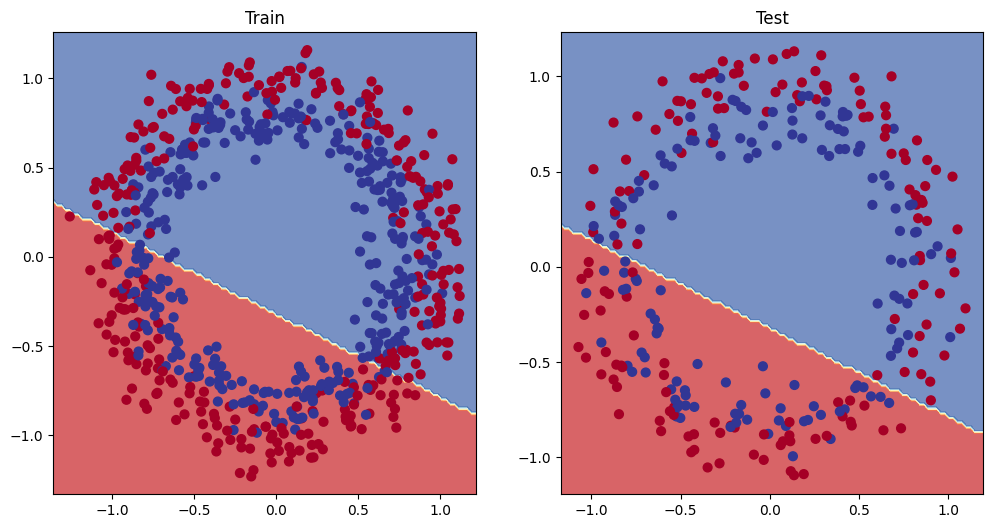

In [9]:
#ok from the result above we can see the model is not learning or  training well
# Why? because we are using only linear layers and the data we have is not linearly separable
# lets see what this means
import numpy as np

def plot_prediction(train_data, train_label, test_data, test_label, prediction=None):
    plt.figure(figsize=(7,3))
    plt.scatter(train_data, train_label, c='g', s=3, label='Training data' ) # c is for color, s is for size of the dots
    plt.scatter(test_data, test_label, c='b', s=3 , label='Test data')
    
    if prediction is not None: 
        plt.scatter(test_data, prediction, c='r', s=3, label='Prediction' )
    
    plt.legend(prop={'size':14})
    
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    """Plots decision boundaries of model predicting on X in comparison to y.

    Source - https://madewithml.com/courses/foundations/neural-networks/ (with modifications)
    """

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_circle_0 , X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_circle_0, X_test, y_test)


So the above model is clearly not performing well
what is missing? the missing piece is adding non linearity to our model. As seen above a simple line can not acurately separate the two classes

In [10]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([700, 2]),
 torch.Size([300, 2]),
 torch.Size([700]),
 torch.Size([300]))

In [11]:
class CircleModelImproved(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1= nn.Linear(in_features=2 , out_features=8)
        self.layer2= nn.Linear(in_features=8, out_features=4)
        self.layer3= nn.Linear(in_features=4, out_features=1)
        self.relu= nn.ReLU()
    
    def forward(self, x:torch.Tensor)->torch.Tensor:
        rslt= self.layer1(x)
        rslt= self.relu(rslt)
        rslt= self.layer2(rslt)
        rslt= self.relu(rslt)
        rslt= self.layer3(rslt)
        return rslt
    
model_circle_1= CircleModelImproved()
lossFn= torch.nn.BCEWithLogitsLoss()
optmzr= torch.optim.Adam(params= model_circle_1.parameters(), lr=0.01)
epochs=5000
for epoch in range(epochs):
    model_circle_1.train()
    yy_logit_train= model_circle_1(X_train).squeeze()
    yy_pred_train= torch.round(torch.sigmoid(yy_logit_train))
    accr= accuracy_score(y_train.detach().numpy(), yy_pred_train.detach().numpy())
    loss_1_train= lossFn(yy_logit_train, y_train)
    
    optmzr.zero_grad()
    
    loss_1_train.backward()
    
    optmzr.step()
    model_circle_1.eval()
    with torch.inference_mode():
        yy_logit_test= model_circle_1(X_test).squeeze()
        yy_pred_test= torch.round(torch.sigmoid(yy_logit_test))
        accr_test= accuracy_score(y_test.detach().numpy(), yy_pred_test.detach().numpy())
        
        loss_1_test= lossFn(yy_logit_test, y_test)
        
        if epoch % 500 == 0:
            print(f"Train loss: {loss_1_train} ---------- Test loss: {loss_1_test}")
            print(f"Train accuracy: {accr} ---------- Test accuracy: {accr_test}")

print(yy_logit_train.shape)
print(y_train.shape)
print(y_train.dtype)

    


Train loss: 0.713941752910614 ---------- Test loss: 0.7000634074211121
Train accuracy: 0.49142857142857144 ---------- Test accuracy: 0.52
Train loss: 0.31336313486099243 ---------- Test loss: 0.5385512113571167
Train accuracy: 0.8685714285714285 ---------- Test accuracy: 0.74
Train loss: 0.31198757886886597 ---------- Test loss: 0.5392758846282959
Train accuracy: 0.8671428571428571 ---------- Test accuracy: 0.75
Train loss: 0.3115431070327759 ---------- Test loss: 0.5406388640403748
Train accuracy: 0.8671428571428571 ---------- Test accuracy: 0.75
Train loss: 0.3106725811958313 ---------- Test loss: 0.5359704494476318
Train accuracy: 0.8671428571428571 ---------- Test accuracy: 0.7633333333333333
Train loss: 0.31004199385643005 ---------- Test loss: 0.5374221205711365
Train accuracy: 0.8657142857142858 ---------- Test accuracy: 0.7633333333333333
Train loss: 0.3098590672016144 ---------- Test loss: 0.5374770760536194
Train accuracy: 0.8657142857142858 ---------- Test accuracy: 0.763333

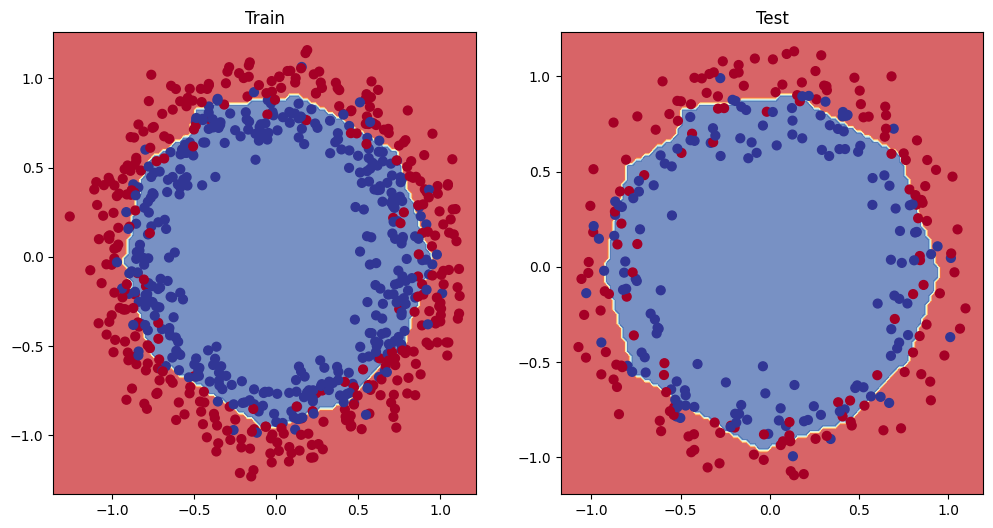

In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_circle_1 , X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_circle_1, X_test, y_test)